In [1]:
from torchdrug import transforms
from torchdrug import data, core, layers, tasks, metrics, utils, models
from torchdrug.layers import functional
from torchdrug.core import Registry as R

import torch
from torch.utils import data as torch_data
from torch.nn import functional as F
from lib.tasks import NodePropertyPrediction
from lib.datasets import ATPBind
from transformers import BertModel, BertTokenizer

truncuate_transform = transforms.TruncateProtein(max_length=350, random=False)
protein_view_transform = transforms.ProteinView(view='residue')
transform = transforms.Compose([truncuate_transform, protein_view_transform])

dataset = ATPBind(atom_feature=None, bond_feature=None,
                  residue_feature="default", transform=transform)

train_set, valid_set, test_set = dataset.split()


def _freeze_bert(
    bert_model: BertModel, freeze_bert=True, freeze_layer_count=-1
):
    """Freeze parameters in BertModel (in place)

    Args:
        bert_model: HuggingFace bert model
        freeze_bert: Bool whether or not to freeze the bert model
        freeze_layer_count: If freeze_bert, up to what layer to freeze.

    Returns:
        bert_model
    """
    if freeze_bert:
        # freeze the entire bert model
        for param in bert_model.parameters():
            param.requires_grad = False
    else:
        # freeze the embeddings
        for param in bert_model.embeddings.parameters():
            param.requires_grad = False
        if freeze_layer_count != -1:
            # freeze layers in bert_model.encoder
            for layer in bert_model.encoder.layer[:freeze_layer_count]:
                for param in layer.parameters():
                    param.requires_grad = False
    return None

# Cusom model Wrapping BERT: check https://torchdrug.ai/docs/notes/model.html


class BertWrapModel(torch.nn.Module, core.Configurable):
    def __init__(self, freeze_bert, freeze_layer_count):
        super().__init__()
        self.bert_tokenizer = BertTokenizer.from_pretrained(
            "Rostlab/prot_bert", do_lower_case=False)
        self.bert_model = BertModel.from_pretrained(
            "Rostlab/prot_bert").to('cuda')
        _freeze_bert(self.bert_model, freeze_bert=freeze_bert,
                     freeze_layer_count=freeze_layer_count)
        self.input_dim = 21
        self.output_dim = self.bert_model.config.hidden_size

    def forward(self, graph, _, all_loss=None, metric=None):
        # print("graph: ", graph)
        # print("sequence: ", graph.to_sequence())
        input = [seq.replace('.', ' ') for seq in graph.to_sequence()]

        encoded_input = self.bert_tokenizer(
            input, return_tensors='pt').to('cuda')
        # print("Input size: ", encoded_input["input_ids"].size())
        x = self.bert_model(**encoded_input)
        # print("Output size just after model: ", x.last_hidden_state.size())

        # skip residue feature for [CLS] and [SEP], since they are not in the original sequence
        return {"residue_feature": torch.squeeze(x.last_hidden_state)[1:-1]}


Split num:  [346, 42, 41]


In [2]:
bert_wrap_model = BertWrapModel(freeze_bert=False, freeze_layer_count=29)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
import time
import logging 

class DisableLogger():
    def __enter__(self):
       logging.disable(logging.CRITICAL)
    def __exit__(self, exit_type, exit_value, exit_traceback):
       logging.disable(logging.NOTSET)
    
logging.basicConfig(level='error')

ls = []
runtimes = []

for freeze_layer_count in range(30, 21, -1):
    torch.cuda.empty_cache()
    with DisableLogger():
        bert_wrap_model = BertWrapModel(
            freeze_bert=False, freeze_layer_count=freeze_layer_count)
        bert_task = NodePropertyPrediction(
            bert_wrap_model, normalization=False, num_mlp_layer=2, metric=("micro_auroc", "micro_auprc", "macro_auprc", "macro_auroc"))
        optimizer = torch.optim.Adam(
            bert_task.parameters(), lr=1e-3)
        solver = core.Engine(bert_task, train_set, valid_set,
                            test_set, optimizer, batch_size=1, log_interval=100000, gpus=[0])
        start_time = time.time()
        solver.train(num_epoch=1)
        end_time = time.time()
        runtime = end_time - start_time
        runtimes.append(runtime)

        res = solver.evaluate("test")
        print(f"at freeze_layer_count: {freeze_layer_count}, runtime: {runtime}, auroc = {res['micro_auroc']}")
        ls.append(res)

at freeze_layer_count: 30, runtime: 20.393354892730713, auroc = 0.844639241695404
at freeze_layer_count: 29, runtime: 22.526334047317505, auroc = 0.8894146084785461
at freeze_layer_count: 28, runtime: 25.061904430389404, auroc = 0.8493391871452332
at freeze_layer_count: 27, runtime: 26.588226556777954, auroc = 0.5333211421966553
at freeze_layer_count: 26, runtime: 28.83957552909851, auroc = 0.5338866710662842
at freeze_layer_count: 25, runtime: 31.213543176651, auroc = 0.5379442572593689
at freeze_layer_count: 24, runtime: 33.40590023994446, auroc = 0.5027700066566467
at freeze_layer_count: 23, runtime: 35.50039458274841, auroc = 0.5209774374961853
at freeze_layer_count: 22, runtime: 37.87410020828247, auroc = 0.5119636654853821


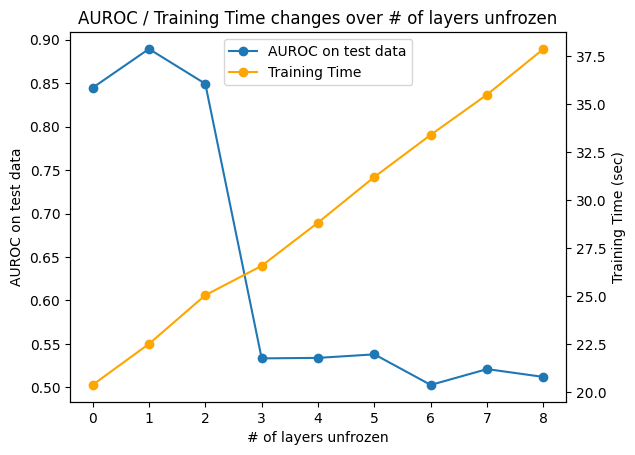

In [5]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
auroc = [i['micro_auroc'].item() for i in ls]

# Create an array for the x-axis representing the index of each element in the arrays
x = np.arange(len(auroc))

# Create the first plot for AUROC
fig, ax1 = plt.subplots()

ax1.plot(x, auroc, label='AUROC on test data', marker='o')
ax1.set_xlabel('# of layers unfrozen')
ax1.set_ylabel('AUROC on test data')
ax1.tick_params(axis='y')

# Create the second plot for runtime
ax2 = ax1.twinx()

ax2.plot(x, runtimes, label='Training Time', marker='o', color='orange')
ax2.set_ylabel('Training Time (sec)')
ax2.tick_params(axis='y')

# Set up the title for the chart
plt.title('AUROC / Training Time changes over # of layers unfrozen')

# Add a legend to indicate which line represents which array
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center')

# Display the chart
plt.show()
